<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/01_Introduction_to_Generative_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Hands on Intro to Generative Modeling Using HF Diffusers.

In [1]:
!pip install -Uq diffusers transformers fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00


In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(44)
if not (Path.home()/'.cache/huggingface' / 'token').exists(): notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Setting Up the Stable Diffusion Pipeline

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               variant="fp16",
                                               torch_dtype=torch.float16).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Checking location of the model weights
!ls ~/.cache/huggingface/hub

models--CompVis--stable-diffusion-v1-4	version_diffusers_cache.txt  version.txt


In [ ]:
# In case the GPU has insufficient memory
# pipe.enable_attention_slicing()

In [10]:
# Testing first prompt
prompt = "a poster of a samurai on a racing motorbike"

  0%|          | 0/50 [00:00<?, ?it/s]

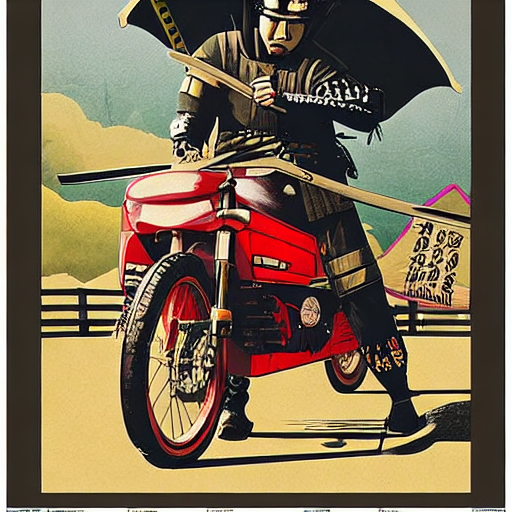

In [11]:
pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

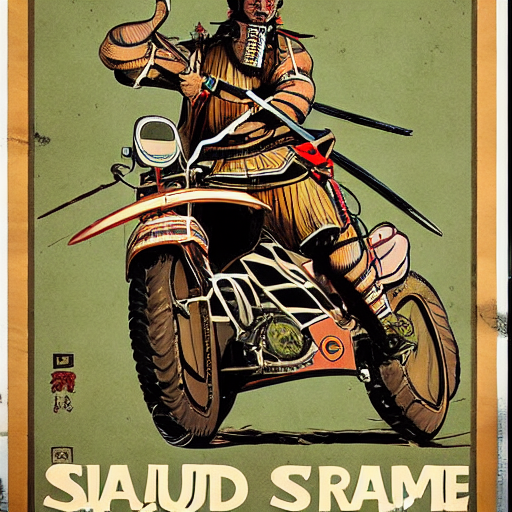

In [12]:
# Using different seed values
torch.manual_seed(8161)
pipe(prompt).images[0]

As diffusion models generate images from random noise after a series of steps, we can play around with the number of steps to see the effects on the model's outputs.

  0%|          | 0/3 [00:00<?, ?it/s]

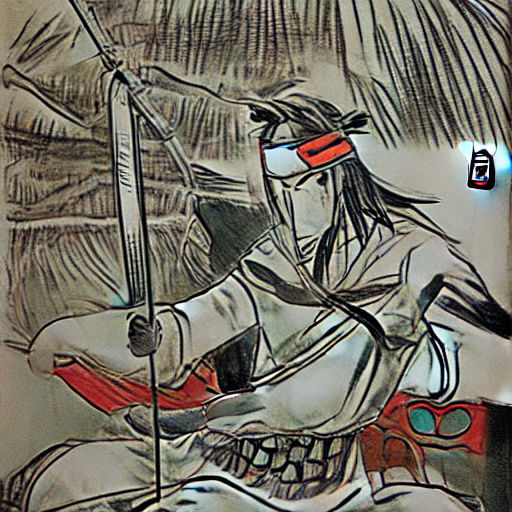

In [14]:
# Taking the manual  seed setting from the last cell
torch.manual_seed(8161)
pipe(prompt, num_inference_steps=3).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

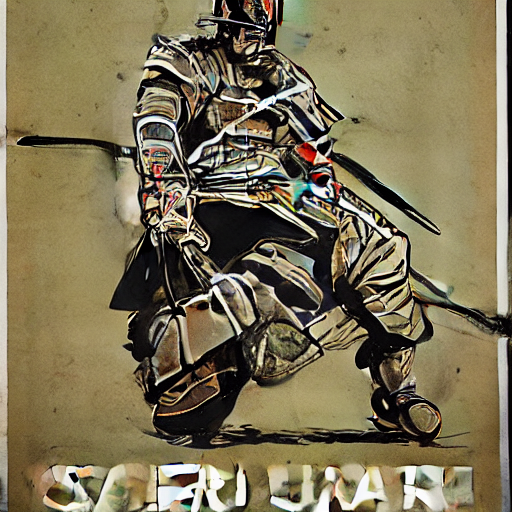

In [15]:
# Increase the number of steps to 10
torch.manual_seed(8161)
pipe(prompt, num_inference_steps=10).images[0]

  0%|          | 0/16 [00:00<?, ?it/s]

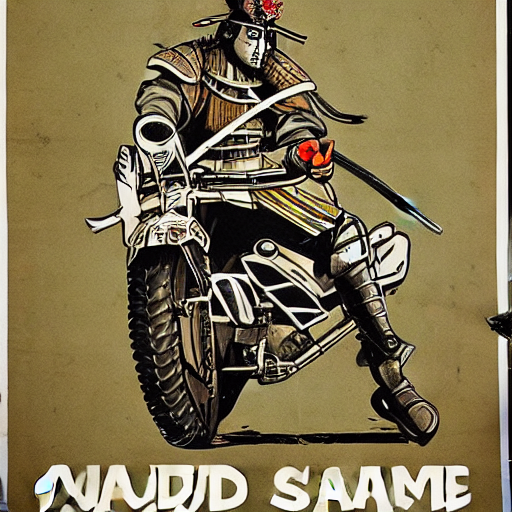

In [16]:
# Increase the number of steps to 16
torch.manual_seed(8161)
pipe(prompt, num_inference_steps=16).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

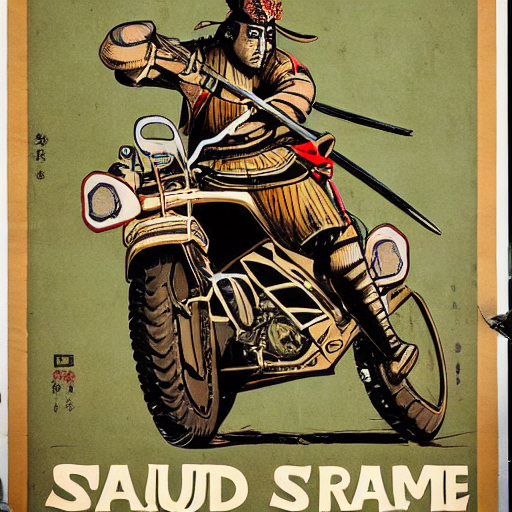

In [19]:
# Let's take it up to 40
torch.manual_seed(8161)
pipe(prompt, num_inference_steps=40).images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

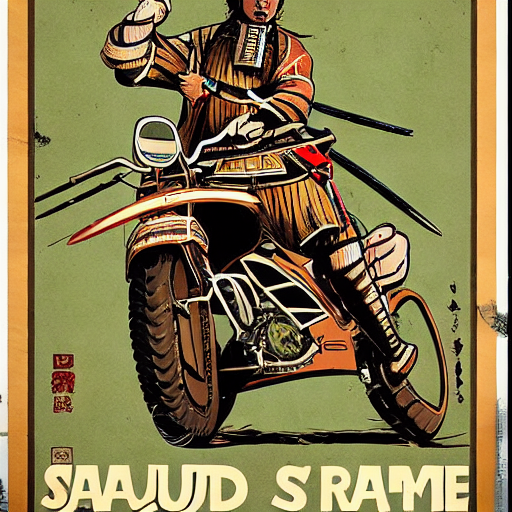

In [20]:
# Cranking to 100
torch.manual_seed(8161)
pipe(prompt, num_inference_steps=100).images[0]

## Classifier Free Guidance


In [22]:
def image_grid(imgs, rows, cols):
  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols * w, rows * h))
  for i, img in enumerate(imgs):
    grid.paste(img, box=(i % cols * w, i // cols * h))
  return grid